# Project Statement

Explore the impact of a non-constant volatility term $\sigma $ on the
distribution of profits of delta hedging. You are encouraged to research
and explore a $\sigma $ hedging stategy and write code that simulates
the profit distribution of the $\sigma $ hedging strategy

# Given Code

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')


In [ ]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.

    Each step of the log-returns, there is a
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45

    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path

    Returns:

    Simuatled stock paths
    '''

    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))

    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))

    #Time increment between each step
    dt = t/n_steps

    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise

    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)


    #paths
    paths = S0*np.exp(log_returns)


    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)


    return paths


In [ ]:
S0 = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 5
n_steps = 252

simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)
plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)

plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)
plt.show()


# Helper Functions

**Note: This section can be safely skipped.** We simply set up our Monte
Carlo simulation functions to accept generic functions that product
stock price paths, and price the options and estimate delta accordingly.
We then adapt the function to simulate of delta hedging to use the
generic pricer and delta computer.

## Monte Carlo Options Pricer

In [ ]:
def mc_pricer(S0,T,n_paths,n_steps,K,path_gen,callput, **kwargs):
    """
    Monte-Carlo pricer with generic stock path generator.


    Inputs:
    S0 (float, array) - Spot
    T - Time to expiration in years
    r - Risk Free Rate
    mu - Stock drift
    n_paths - Number of simulations
    n_steps - Number of steps to take on each path
    K - Strike Price
    path_gen (callable) - Function taking args
            S0,T,r,mu,n_paths,n_steps, with possibly more
    callput (string) - Call or put option
    **kwargs - Extra arguments to pass to path_gen callable

    Return:
    Array of option prices for each spot
    """
    S0 = np.array(S0)
    s = S0.size


    paths = path_gen(S0,T,n_paths,n_steps,**kwargs)[0]
    if callput == "CALL":
        paths = np.reshape(paths,(-1,n_paths,n_steps))
        payoff = np.maximum(paths[:,:,-1] - K, 0)*np.exp(-r*T)
        return np.mean(payoff,axis=1)
    if callput == "PUT":
        paths = np.reshape(paths,(-1,n_paths,n_steps))
        payoff = np.maximum(K-paths[:,:,-1] , 0)*np.exp(-r*T)
        return np.mean(payoff,axis=1)



## Monte Carlo Option Delta

We use the Monte Carlo option pricer to estimate option delta using the
second order finite difference estimation.

In [ ]:
def mc_delta(S0, T,delta_sims,K,path_gen,callput,**kwargs):
    """
    Monte Carlo estimation of Black-Scholes call deltas for an array of spot prices
    with stochastic volatility model (discrete distribution).

    Parameters:
    S0 (float, array) - Spot
    T - Time to expiration in years
    delta_sims (int): Number of simulations
    K - Strike Price
    path_gen (callable) - Function taking args
            S0,T,r,mu,n_paths,n_steps, with possibly more
    callput (string) - Call or put option
    **kwargs - Extra arguments to pass to path_gen callable, such as mu,r, etc.


    Return
    array: simulated delta(s) of call option
    """
    S0 = np.array(S0)
    bump = 0.01 * S0

    del_steps = 50
    try:
        del_steps = kwargs["del_steps"]
    except:
        del_steps = 50

    try:
        n = kwargs["noise"]
        if n is True:
            if str(path_gen) in ["stock_path_constant_sigma","cev_path","GARCH11_paths"]:
                noise = np.random(0,1,(n_paths*s[0],n_steps))
                print(noise)
                kwargs.update({"noise":noise})
            else:
                noise = (np.random(0,1,(n_paths*n[0],n_steps)),np.random(0,1,(n_paths*n[0],n_steps)))
                kwargs.update({"noise":noise})

    except:
        pass

    down = mc_pricer(S0-bump,T,delta_sims,del_steps,K,path_gen,callput,**kwargs)
    up = mc_pricer(S0+bump,T,delta_sims,del_steps,K,path_gen,callput,**kwargs)


    deltas = (up - down) / (2 * bump)
    s = deltas.shape
    if len(s) > 1:
        return np.mean(deltas, axis=0)
    else:
        return deltas



In the absence of a rigorous convergence analysis for the Monte Carlo
pricer, we choose to calculate the value of the option with a 50 step
path generation, relying on the central limit theorem to give a more
precise estimation of delta as the number of simulations increases.

## Selling options with hedging

In [ ]:
def mc_hedge_profits(S0, T, n_sims,n_steps,delta_sims , n_hedges, K, path_gen, callput, **kwargs):

    """Description
    Monte-Carlo simulation of the Black-Scholes value of a call option with Delta based control variants


    Parameters:
    S0 (float): spot price
    T (float): time to expiration
    n_sims (int): Number of simulations
    n_steps (int): Steps for MC option pricing
    delta_sims (int): number of sims for delta approximation
    n_hedges (int): number of delta control variants at evenly spaced increments
    K (float): strike price
    path_gen (callable): Function taking S0,T,n_sims,n_steps for stock path generation
    callput (string): "CALL" or "PUT"
    **kwargs: Additional arguments for mc_delta and path_gen function, such as mu,r
               sigma,etc.

    Return:
    np.array of simulated values of Black-Scholes value of call option
    """
    r = kwargs["r"]

    dt = T/n_hedges
    paths = path_gen(S0,T,n_sims,n_hedges,**kwargs)[0]
    path_ends = paths[:,-1]
    payoffs = np.maximum(path_ends - K, 0)*np.exp(-r*T)


    #Simulate stock profits at each interval

    ## profit from start to first step discounted to time 0

    paths_first_step = paths[:,0]
    delta_start = mc_delta(S0,T,delta_sims,K,path_gen,callput,**kwargs)
    stock_profits_start = (paths_first_step - np.exp(r*dt)*S0)*delta_start*np.exp(-r*dt)
    total_stock_profits = np.zeros((n_sims,n_hedges-1))
    total_stock_profits = np.concatenate((stock_profits_start.reshape(n_sims,-1),total_stock_profits), axis = 1)

    ## stock profits in intermediate steps
    try:
        noise = kwargs["crn"]
        if noise is True:
            kwargs.update({"crn": True})
    except:
        pass

    def calc_prof(i):
        tte = T - i*dt
        deltas = mc_delta(paths[:,i-1],tte,delta_sims,K,path_gen,callput,**kwargs)
        total_stock_profits[:,i] = (paths[:,i] - paths[:,i-1]*np.exp(r*dt))*deltas*np.exp(-r*(i+1)*dt)

    Parallel(n_jobs=2)(delayed(calc_prof)
                          (i)
                             for i in range(1,n_hedges))


    stock_profits = np.sum(total_stock_profits, axis = 1)

    profits_hedged = payoffs - stock_profits

    return profits_hedged


# Distributions of $\Delta $ Hedge Profits

We establish a consistent set of parameters common to all of our tests,
so that the only factors should be the volatility models we use.

In [ ]:
from joblib import Parallel, delayed

# Selling 1Y 110C @ spot 100
S0 = 100
K = 110
T = 1

r = 0.039
# Neutral-to-upward trending prices
mu = 0.1

# Long term volatility for the models that need it
sigma = 0.15

# Number of simulations
n_sims = 1500

#  Number of simulations for delta calculations
delta_sims = 1000
del_steps = 50
# Number of times to hedge
n_hedges = 252
hedge_nums = [5, 50, 126,252]


## Constant Volatility

To establish a control for what we should compare our profit/loss
distributions against, we will model a portfolio of selling calls with
delta hedging $N$ times on a stock with risk-neutral drift with constant
volatility.

In [ ]:
def stock_path_constant_sigma(S0, t, n_paths, n_steps, **kwargs):
    '''
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path

    Returns:

    Simuatled stock paths
    '''

    sigma = kwargs["sigma"]
    r = kwargs["r"]
    mu = kwargs["mu"]

    S0 = np.array(S0)
    num_spots = S0.size

    S0 = np.repeat(S0,n_paths,axis=0)
    #Noise in volatility
    noise = None
    try:
        noise = kwargs["noise"]
    except:
        noise = np.random.normal(0,1,size = (num_spots*n_paths, n_steps))

    #Custom sigma that is not constant
    sigma = np.full((num_spots*n_paths, n_steps),  sigma)

    #Time increment between each step
    dt = t/n_steps

    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise

    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)


    S0_big = np.expand_dims(S0,1)
    paths = np.repeat(S0_big,log_returns.shape[1],axis=1)*np.exp(log_returns)


    #Adjoint initial value S0 at start of each simulated path
    # paths = np.insert(paths, 0, S0, axis = 1)


    return paths,sigma


In [ ]:
def plot_paths(paths,title):
    plt.title(title)
    for path in paths:
        plt.plot(path)
    plt.show()
paths =  stock_path_constant_sigma(S0,t,10,
                                   252,
                                   sigma=sigma,
                                   r=r,mu=mu)[0]
plot_paths(paths,f"Simulated Paths; Constant volatility $\\sigma = {sigma}$")


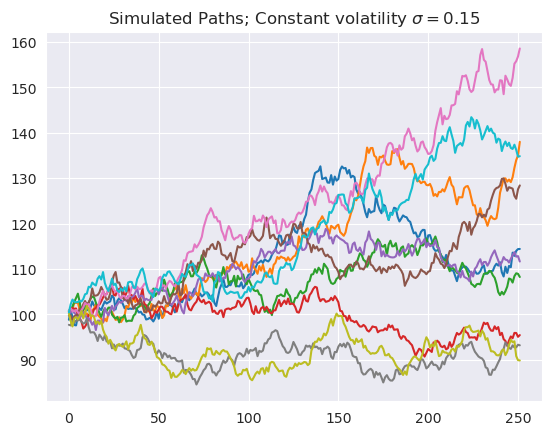

In [ ]:
pather = stock_path_constant_sigma
f,ax = plt.subplots(2,2,figsize=(13,11))
profits = Parallel(n_jobs=2)(delayed(mc_hedge_profits)(S0,
                                                       T,
                                                1000,0,
                          delta_sims,n,K,
                          pather, "CALL",sigma=sigma,r=r,mu=mu,del_steps=del_steps,
                                                       crn=True)
                             for n in hedge_nums)


for (i,n) in enumerate(hedge_nums):
    j = i//2
    k = i%2
    ax[j,k].hist(profits[i],bins=50,label="Simulated Profits",color='black')
    ax[j,k].axvline(np.min(profits[i]),label=f"Max loss: {np.min(profits[i]):.2f}",color='red')
    ax[j,k].axvline(np.max(profits[i]),label=f"Max gain: {np.max(profits[i]):.2f}",color='blue')
    ax[j,k].axvline(np.mean(profits[i]),label=f"Mean P/L: {np.mean(profits[i]):.2f}",color='green')
    ax[j,k].set_title(f"Profits with drift {mu}. {n} Hedges. $\\sigma = {sigma}$")
    ax[j,k].legend()

plt.show()


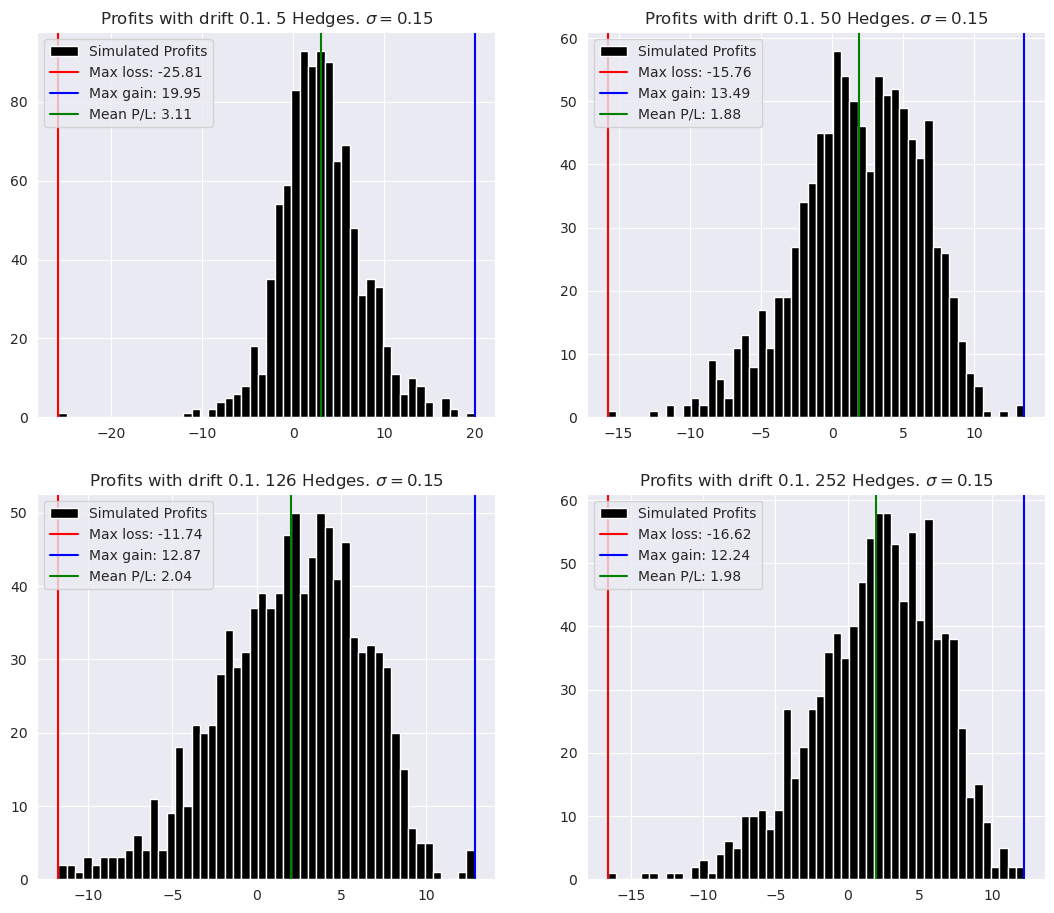

## Constant Elasticity of Variance Model

The constant elasticity of variance (CEV) model is another stochastic
volatility model and is a superset of geometric Brownian motion. It is
one of the simpler *local volatility* models, where the drift term
multiplied by the random noise depends on time and the current asset
price $S_t$.

The (Euler-Maruyama) discretized CEV dynamics obey
$$S_t = S_t + \mu S_{t-1}\tau  + \sigma S^{\gamma }_{t-1} \sqrt{\tau } Z_t $$
where $\sigma,\gamma  \geqslant 0 $ and $\mu  $ is a drift term and
$\tau  = \frac{T}{n}$. Note that at $\gamma =1$, the dynamics match that
of geometric Brownian motion.

In [ ]:
def cev_path(S0,T,n_paths,n_steps,**kwargs):
    gamma = kwargs["gamma"]
    sigma = kwargs["sigma"]
    mu = kwargs["mu"]

    S0 = np.array(S0)
    num_spots = S0.size
    S0 = np.repeat(S0,n_paths,axis=0)

    #Noise in volatility

    try:
        Z = kwargs["noise"]
    except:
        Z = np.random.normal(0,1,size = (num_spots*n_paths, n_steps))

    # Log returns at each step
    prices = np.zeros((num_spots*n_paths,n_steps-1))
    prices = np.insert(prices,0,S0,axis=1)
    # print(prices)
    dt = T/n_steps

    for i in range(1,n_steps):
        prices[:,i] = prices[:,i-1]+mu*prices[:,i-1]*dt+sigma*(prices[:,i-1]**gamma)*np.sqrt(dt)*Z[:,i]

    prices = prices*np.exp(-r*T)

    return (prices,sigma)


In [ ]:
# Elasticity term
gamma = 0.9

plot_paths(cev_path([S0],T,10,250,sigma=sigma,mu=mu,gamma=gamma)[0],
           title="Simulated CEV Paths")


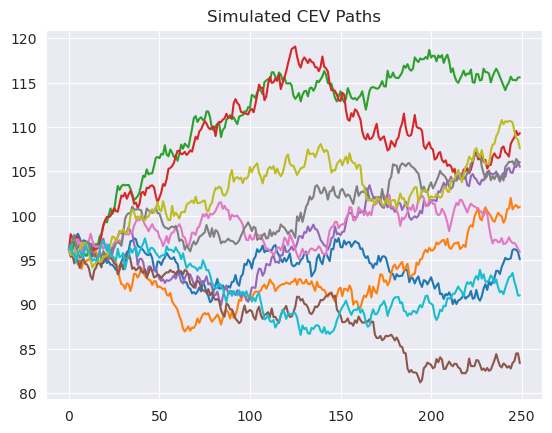

Notably, as $\gamma $ gets closer to $0$, the stochastic term vanishes,
and the dynamics become almost linear with slope equal to the drift.
Values of $\gamma <1$ produce dynamics of volatility where the
volatility (or diffusion) term $\sigma S^{\gamma-1 }_t$ increases as the
stock price decreases, which is something empirically seen in equity
markets.

Let us simulate a delta neutral portfolio with these paths.

In [ ]:
pather = cev_path

f,ax = plt.subplots(2,2,figsize=(13,11))

profits = Parallel(n_jobs=4)(delayed(mc_hedge_profits)(S0,
                                                       T,
                                                       1000,0,
                          delta_sims,n,K,
                          pather, "CALL",sigma=sigma,gamma=gamma,
                          r=r,mu=mu,crn=True)
                             for n in hedge_nums)

for (i,n) in enumerate(hedge_nums):
    j = i//2
    k = i%2
    ax[j,k].hist(profits[i],bins=50,label="Simulated Profits",color='black')
    ax[j,k].axvline(np.min(profits[i]),label=f"Max loss: {np.min(profits[i]):.2f}",color='red')
    ax[j,k].axvline(np.max(profits[i]),label=f"Max gain: {np.max(profits[i]):.2f}",color='blue')
    ax[j,k].axvline(np.mean(profits[i]),label=f"Mean P/L: {np.mean(profits[i]):.2f}",color='green')
    ax[j,k].set_title(f"Profits with drift {mu}. {n} Hedges. CEV $\\gamma={gamma}$")
    ax[j,k].legend()

plt.show()


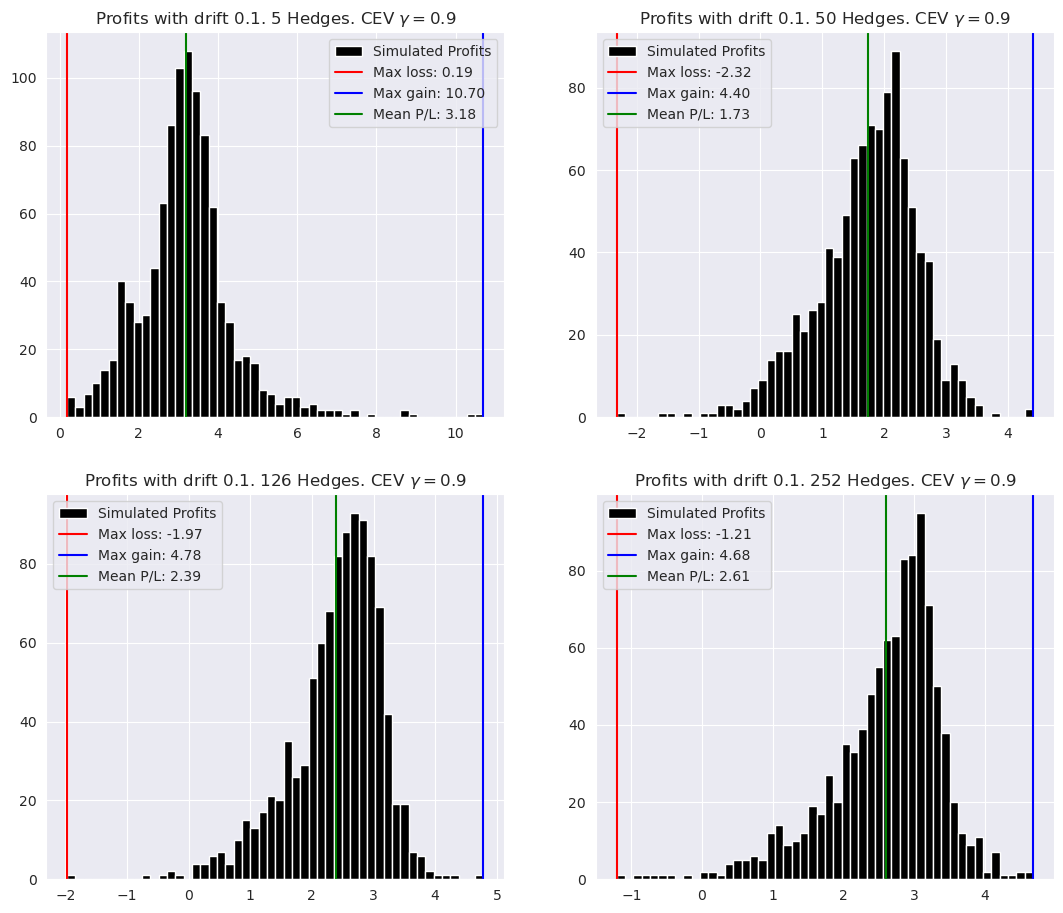

## Hull-White Stochastic Volatility with Drift

The CEV model's diffusion term depended on both $t$ and $S_t$. There is
yet another superset of these local volatility models called *stochastic
volatility models*, where the volatility term follows a stochastic
differential equation in its own right. The Hull-White stochastic
volatility model is one such example, which we consider here.

Let $S_t,\sigma _t$ denote the price and volatility of an asset at time
$t$. The Hull-White process with drift has dynamics
$$dS_t= \mu S_t \,dt+\sigma _t S_t\, dW_t$$
$$d\sigma _t = \omega \sigma _t \,dZ_t$$ where $\omega $ is a positive
real number, $\mu $ is a drift term, and $W_t,Z_t$ are iid normally
distributed variables. The standard Hull-White stochastic volatility
model does not include a drift term, but we add one to make it
comparable to our other model choices.

The Euler-Maruyama discretization of $S_t$ gives
$$S_{i+1} = S_i+S_i \left( \mu\tau  + \sigma \sqrt{\tau }\epsilon _{i} \right)$$
$$\sigma _{i+1} = \sigma _i \exp \left( \omega \sqrt{\tau }V_i - \frac{1}{2}\omega   _i^{2} \tau  \right)$$
where $\tau  = \frac{T}{n}$, the step length on an interval of time.

We can rewrite the differences of normal distributions as
$W_{i+1} -W_i = \sqrt{\tau }\epsilon _i$ and
$Z_{i+1} - Z_i = \sqrt{\tau }V_i$ where $V_i,\epsilon _i$ are again
normally distributed iid variables. Details of this can be found in
*Asymptotics for the Euler-discretized Hull-White Stochastic Volatility
Model*. Note that this is not the same as the Hull-White interest rate
model.

In [ ]:
def hull_white_path(S0,T,n_paths,n_steps,**kwargs):
    omega = kwargs["omega"]
    sig0 = kwargs["sig0"]
    mu = kwargs["mu"]

    S0 = np.array(S0)
    num_spots = S0.size

    S0 = np.repeat(S0,n_paths,axis=0)
    #Noise in volatility
    try:
        V = kwargs["noise"]
        eps = V[0]
        V = V[1]
    except:
        V = np.random.normal(0,1,size = (num_spots*n_paths, n_steps))
        eps = np.random.normal(0,1,size = (num_spots*n_paths, n_steps))

    eps = np.random.normal(0,1,size = (num_spots*n_paths, n_steps))
    V = np.random.normal(0,1,size = (num_spots*n_paths, n_steps))

    #Custom sigma that is not constant
    sigma = np.zeros((num_spots*n_paths,n_steps))

    # Initial volatility is long run vol
    sigma[:,0] = np.full(num_spots*n_paths,sig0)

    # Log returns at each step
    prices = np.zeros((num_spots*n_paths,n_steps-1))
    prices = np.insert(prices,0,S0,axis=1)
    dt = T/n_steps

    for i in range(1,n_steps):
        sigma[:,i] = sigma[:,i-1]*np.exp(omega*np.sqrt(dt)*V[:,i]-0.5*omega**2 * dt)
        prices[:,i] =prices[:,i-1] +prices[:,i-1]*(mu*dt + sigma[:,i]*np.sqrt(dt)*eps[:,i])

    return (prices,sigma)


In [ ]:
omega = 0.6

plot_paths(hull_white_path(S0,t,10,250,
                           omega=omega,
                           sig0=sigma,
                           mu=mu)[0],
           title="Simulated Hull-White Paths")


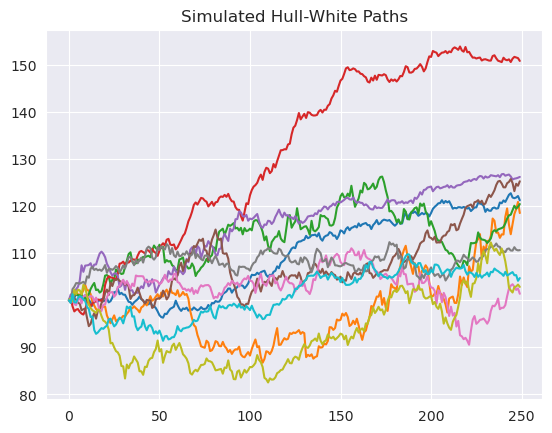

In [ ]:
pather = hull_white_path

f,ax = plt.subplots(2,2,figsize=(13,11))

profits = Parallel(n_jobs=6)(delayed(mc_hedge_profits)(S0,
                                                       T,
                                                       1000,0,
                          delta_sims,n,K,
                          pather, "CALL",omega=omega,
                          r=r,mu=mu,sig0=sigma,crn=True)
                             for n in hedge_nums)

for (i,n) in enumerate(hedge_nums):
    j = i//2
    k = i%2
    ax[j,k].hist(profits[i],bins=50,label="Simulated Profits",color='black')
    ax[j,k].axvline(np.min(profits[i]),label=f"Max loss: {np.min(profits[i]):.2f}",color='red')
    ax[j,k].axvline(np.max(profits[i]),label=f"Max gain: {np.max(profits[i]):.2f}",color='blue')
    ax[j,k].axvline(np.mean(profits[i]),label=f"Mean P/L: {np.mean(profits[i]):.2f}",color='green')
    ax[j,k].set_title(f"Profits with drift {mu}. {n} Hedges. Hull-White $\\omega={omega}$")
    ax[j,k].legend()

plt.show()


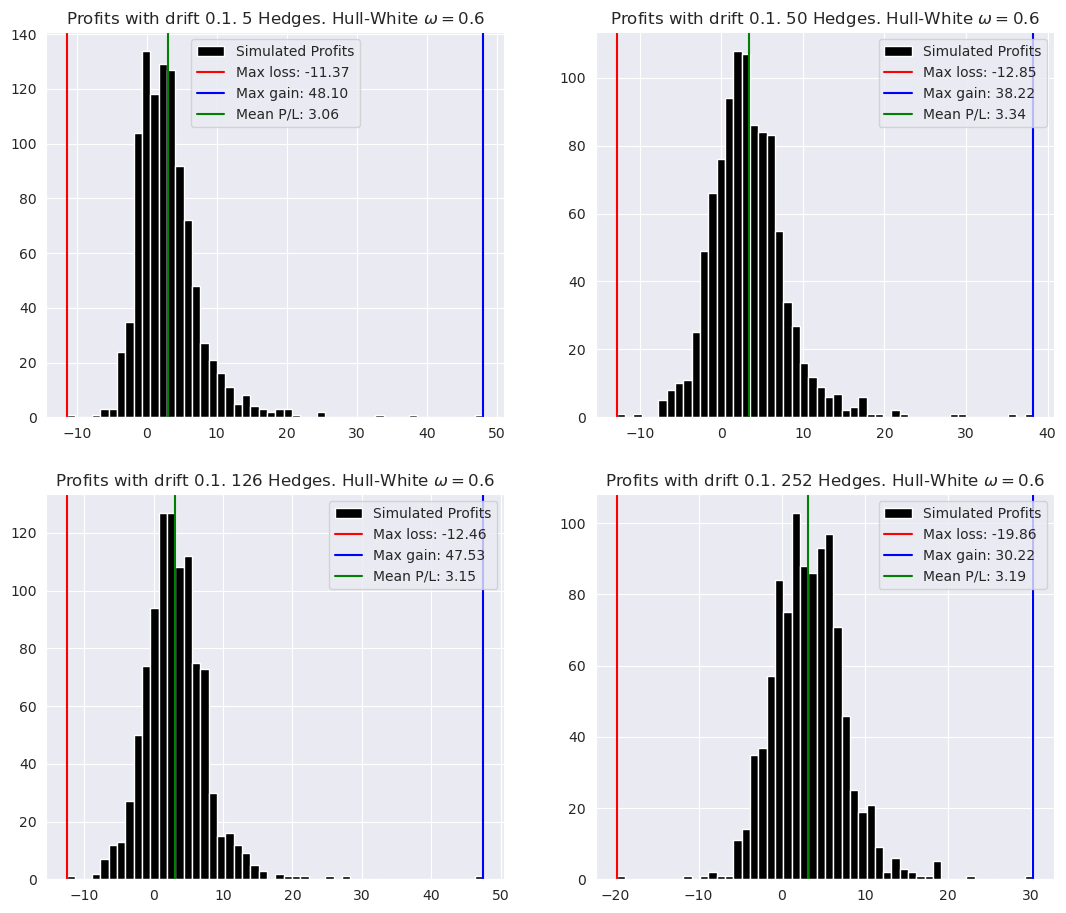

## <span class="todo TODO">TODO</span> GARCH(1,1)

Let $[0,T]$ be a unit of time we want to model the evolution of a stock
log returns over, subdivided into $n$ equally spaced intervals. Let
$r_t$ be the log return of the stock at time $t$. The GARCH(1,1)
computes a time series of volatilites $\sigma _t^{2}$ with $t\in [0,T]$
as a weighted sum of the previous period's volatility
$\sigma _{t-1}^{2}$ and log returns $r_{t-1}^{2}$. It specifies
$$\sigma _{t+1}^2 = \omega  + \alpha \sigma _t^2 + \beta r _t^{2}$$
where $\alpha ,\beta ,\omega $ are positive parameters whose sum is at
most $1$.

Typically, GARCH(1,1) and its relatives are used to fit volatility
models of known time series, and the parameters are usually optimized to
do so according to whatever metrics a practitioner wants. Because we are
modelling forward movements of stocks, we will be choosing them somewhat
arbitrarily, though we will use parameters that resemble the optimized
parameters for stock-like data.

Since this model is inherently recursive, vectorizing it will
unfortunately not be an option. The function can take either a single
spot price, or a list/array of spot prices, and will simulate `n_paths`
for each spot price.

In [ ]:
def GARCH11_paths(S0, t, n_paths, n_steps,**kwargs):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.

    Inputs:
    S0 (float,1d array,list): initial stock value or list of inital values
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    **kwargs
    omega: omega parameter
    alpha: alpha parameter
    beta: beta parameter

    Returns:

    Simulated stock paths
    '''
    omega = kwargs["omega"]
    alpha = kwargs["alpha"]
    beta = kwargs["beta"]
    r = kwargs["r"]
    mu = kwargs["mu"]

    S0 = np.array(S0)
    num_spots = S0.size

    S0 = np.repeat(S0,n_paths,axis=0)
    #Noise in volatility
    try:
        noise = kwargs["noise"]
    except:
        noise = np.random.normal(0,1,size = (num_spots*n_paths, n_steps))

    #Custom sigma that is not constant
    sigma = np.zeros((num_spots*n_paths,n_steps))

    # Initial volatility is long run vol
    sigma[:,0] = np.full(num_spots*n_paths,omega/(1-alpha-beta))

    # Log returns at each step
    increments = np.zeros((num_spots*n_paths,n_steps))
    dt = t/n_steps

    for i in range(1,n_steps):
        sigma[:,i] = omega + alpha*increments[:,i-1]**2 + beta*sigma[:,i-1]
        increments[:,i] = (mu + r - 0.5*sigma[:,i])*dt + np.sqrt(sigma[:,i]*dt)*noise[:,i]


    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    S0_big = np.expand_dims(S0,1)
    paths = S0_big*np.exp(log_returns)


    # paths = np.insert(paths, 0, S0, axis = 1)
    return (paths,sigma)


For example, we can simulate 3 paths each of stocks with starting prices
100, and 100-20.

In [ ]:
g11omega, g11alpha, g11beta = (0.01,0.10,0.60)
paths, sigmas = GARCH11_paths(S0,t,10,252,K=K,
                              omega=g11omega,
                              alpha=g11alpha,
                              beta=g11beta,r=r,mu=mu)
plot_paths(paths,"GARCH(1,1) Simulated Paths")


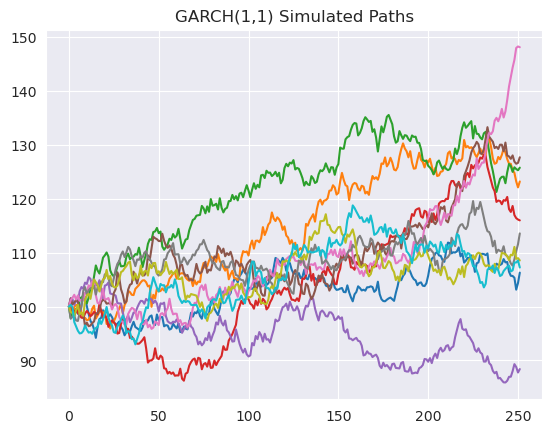

In [ ]:
plt.title("Some Conditional volatilities")
for i in range(2):
    plt.plot(sigmas[i,10:])


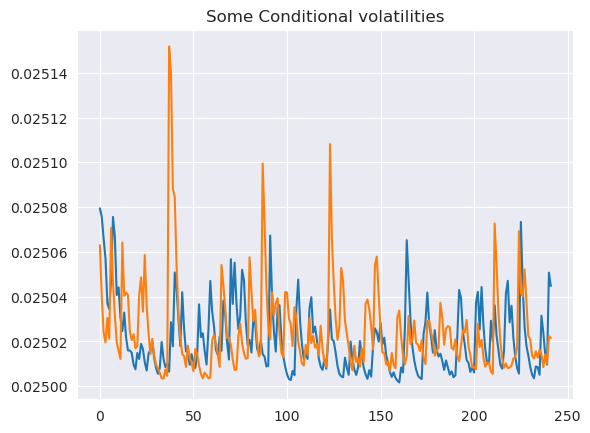

Inspecting the graphs of some the volatility series, we see that the
accounting for previous steps' volatilities causes volatility to "hang
around" when it spikes, which is something observed empirically in stock
data. The interpretation of GARCH parameters remains up for debate, but
inspecting the equation, we can roughly say that $\beta $ represents how
"sticky" volatility tends to be: the smaller the $\beta $, the less the
previous period's volatility affect the current period's volatility.
It's a similar story with $\alpha $, but it controls how the previous
period's price action affects the current period's volatility.

In [ ]:
pather =  GARCH11_paths
f,ax = plt.subplots(2,2,figsize=(13,11))

profits = Parallel(n_jobs=6)(delayed(mc_hedge_profits)(S0,
                                                       T,
                                                       1000,0,
                          delta_sims,n,K,
                          pather, "CALL",omega=g11omega,
                          alpha=g11alpha,beta=g11beta,
                          r=r,mu=mu,sig0=sigma,crn=True)
                             for n in hedge_nums)

for (i,n) in enumerate(hedge_nums):
    j = i//2
    k = i%2
    ax[j,k].hist(profits[i],bins=50,label="Simulated Profits",color='black')
    ax[j,k].axvline(np.min(profits[i]),label=f"Max loss: {np.min(profits[i]):.2f}",color='red')
    ax[j,k].axvline(np.max(profits[i]),label=f"Max gain: {np.max(profits[i]):.2f}",color='blue')
    ax[j,k].axvline(np.mean(profits[i]),label=f"Mean P/L: {np.mean(profits[i]):.2f}",color='green')
    ax[j,k].set_title(f"GARCH(1,1) Profits, {n} Hedges. $(\\omega,\\alpha,\\beta)=({g11omega},{g11alpha},{g11beta})$")
    ax[j,k].legend()

plt.show()


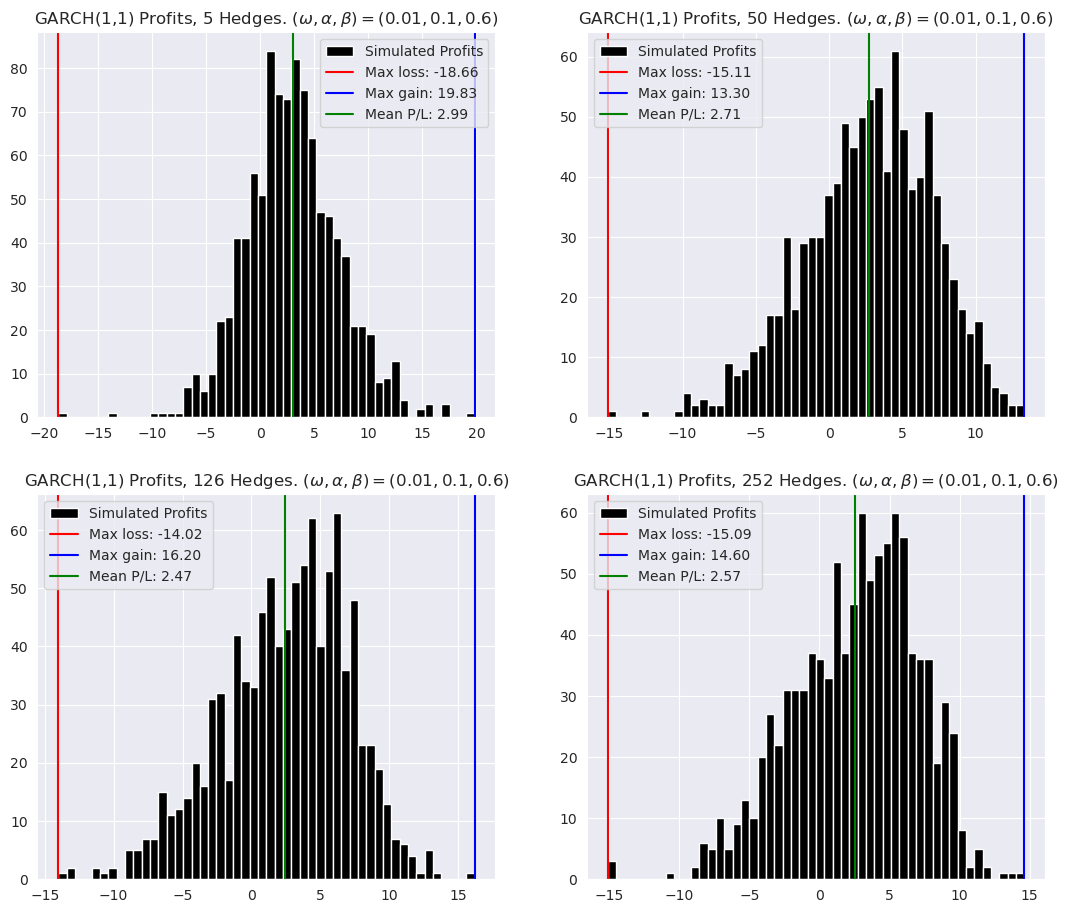

## <span class="done DONE">DONE</span> SABR Volatility Model

The SABR volatility model (with added drift) has dynamics
$$d S_t =\mu S_t+\sigma _tS_t^{\beta }\, dW_t$$
$$d \sigma _t = \alpha \sigma _{t}\, dW^{'}_t$$ where $W_t, W_t'$ are
correlated Brownian motions with correlation $\rho $. A simple
Euler-Maruyama discretization yields discrete dynamics
$$S_{t+1} =S_t+ \mu \tau S_t+ \sigma_tS_t^{\beta }\sqrt{\tau }Z_t$$
$$ \sigma_{t+1} = \sigma _0 \exp \left( \alpha \sqrt{\tau }(\rho Z_t +\sqrt{1-\rho ^2}\epsilon _{t} ) -\frac{1}{2}\alpha ^2\tau \right)$$
Where we have solved for $\sigma _t$ exactly, since it a GBM wirh zero
jump.

In [ ]:
def SABR_path(S0,T,n_paths,n_steps,**kwargs):
    rho = kwargs["rho"]
    mu = kwargs["mu"]
    alpha = kwargs["alpha"]
    beta = kwargs["beta"]
    # initial volatility
    sig0 = kwargs["sigma"]

    S0 = np.array(S0)
    num_spots = S0.size

    S0 = np.repeat(S0,n_paths,axis=0)
    #Noise in volatility
    try:
        Z = kwargs["noise"]
        eps = Z[0]
        Z = Z[1]
    except:
        Z = np.random.normal(0,1,size = (num_spots*n_paths, n_steps))
        eps = np.random.normal(0,1,size = (num_spots*n_paths, n_steps))

    #Custom sigma that is not constant
    sigma = np.zeros((num_spots*n_paths,n_steps))

    # Initial volatility is long run vol
    sigma[:,0] = np.full(num_spots*n_paths,sig0)

    # Log returns at each step
    S = np.zeros((num_spots*n_paths,n_steps-1))
    S = np.insert(S,0,S0,axis=1)
    dt = t/n_steps

    for i in range(1,n_steps):
        sigma[:,i] = sig0*np.exp(alpha*np.sqrt(dt)*(rho *Z[:,i] + np.sqrt(1-rho**2)*eps[:,i]) -0.5*(alpha**2)*dt)
        S[:,i] = (1+mu*dt +sigma[:,i]*(S[:,i-1]**(beta-1))*np.sqrt(dt)*Z[:,i])*S[:,i-1]

    return (S,sigma)



In [ ]:
alpha,beta,rho = 0.25,1,-0.8
paths, sigmas = SABR_path(S0,t,10,250,K=K,
                              alpha=alpha,
                              sigma=0.15,
                              beta=beta,
                              r=r,
                              rho=rho,mu=mu)
plot_paths(paths,"SABR Simulated Paths")


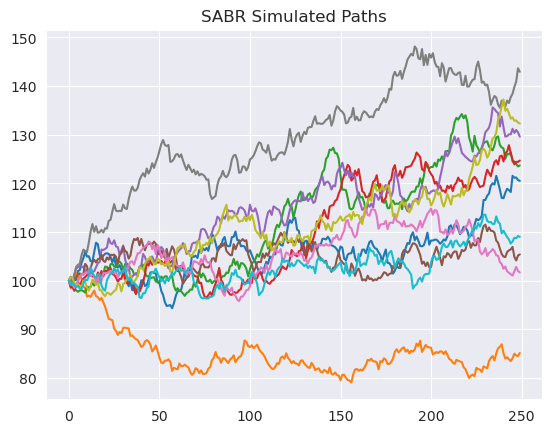

In [ ]:
pather =  SABR_path
f,ax = plt.subplots(2,2,figsize=(13,11))

profits = Parallel(n_jobs=6)(delayed(mc_hedge_profits)(S0,
                                                       T,
                                                       1000,0,
                                                       delta_sims,n,K,
                                                       pather, "CALL",alpha=alpha,
                                                       rho=rho,beta=beta,
                                                       r=r,mu=mu,sigma=sigma)
                             for n in hedge_nums)

for (i,n) in enumerate(hedge_nums):
    j = i//2
    k = i%2
    ax[j,k].hist(profits[i],bins=50,label="Simulated Profits",color='black')
    ax[j,k].axvline(np.min(profits[i]),label=f"Max loss: {np.min(profits[i]):.2f}",color='red')
    ax[j,k].axvline(np.max(profits[i]),label=f"Max gain: {np.max(profits[i]):.2f}",color='blue')
    ax[j,k].axvline(np.mean(profits[i]),label=f"Mean P/L: {np.mean(profits[i]):.2f}",color='green')
    ax[j,k].set_title(f"SABR Hedge Profits, {n} Hedges. $(\\alpha,\\beta,\\rho)=({alpha},{beta},{rho})$")
    ax[j,k].legend()

plt.show()


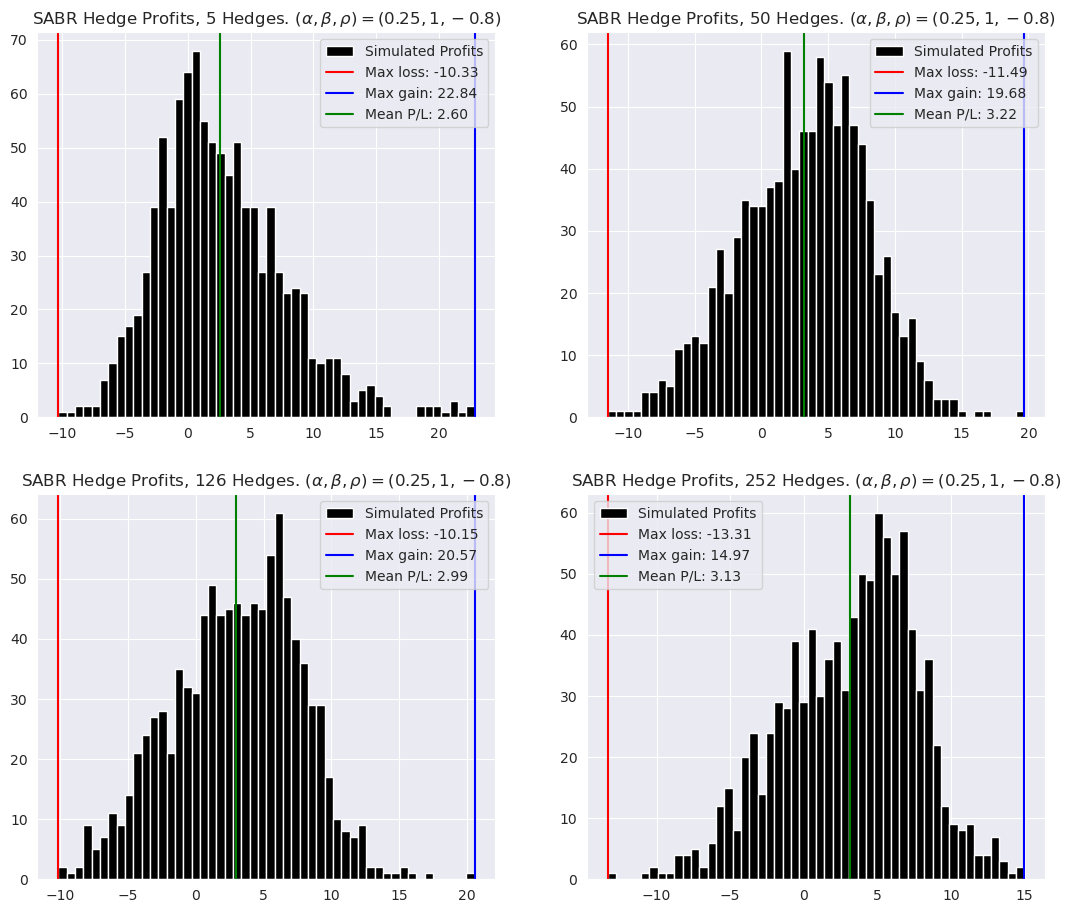

# Commentary

Like with the closed form and simulated Black-Scholes models, even a fer
hedges during the holding period of the strategy increases the
reliability of positive returns and decreases the probability of large
losses. A consistent observation amont all histograms was that the
increase in hedging caused the distribution to be more negatively
skewed, meaning more samples landed to the right of the mean profit.
This further reinforces the importance of regular hedging in those
practicing such a strategy. The one exception to the rule is the
Hull-White distribution, which ended with a distribution still slightly
positively skewed, despite it being an improvement on the lower hedge
number distributions. The Hull-White distribution also stood out among
its local and stochastic volatility peers as looking very different.

The raw numbers of max loss/gain and mean profits are not directly
comparable due to the variety of parameters each model uses, we have
attempted to control the variables that we can to ensure they are
somewhat comparabale, including adding drift terms to those stochastic
proccesses that did not start off life having one. Due to the lack of
uniformly controlled variables going into each process, wildly different
looking stock paths appeared. In particular, the GARCH(1,1) and SABR
systems produce some strange looking paths, with paths resulting in ±30%
change appearing regularly. The options in these models tended to be
more expensive, as the mean payoffs were dragged upwards by the presence
of these "anomalous" paths. Moreover, the difference in local behavior
of volatility seemed to affect the overall shape of the payoff
distribution as the number of hedges increased.

Of note is that our constant volatility payoff distribution does not
seem to resemble that of the Black-Scholes payoff distribution even with
252 hedges. We chalk this up to the disadvantages associated with
simulating every possible value we have computed: the option value and
option delta. Even with a relatively small number of delta simulation
paths and parallel processing added where possible, the code here takes
unbearably long to run. Ideally, more performant code, techniques to
reduce the variance of the Monte Carlo simulations (we've employed
common random numbers), and rigorous convergence analyses are needed to
get the most accurate picture. Of note is we used a naive Euler-Maruyama
discretization scheme on all of our new stochastic processes, which has
relatively poor convergence compared to something like the Milstein
scheme.